In [1]:
# Try determine if gene expression is linked with no. of contacting active regions

setwd("~/HRJ_monocytes")
library(data.table)
library(tidyr)
library(dplyr)
library(ggplot2)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(my_sample)` instead of `my_sample` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


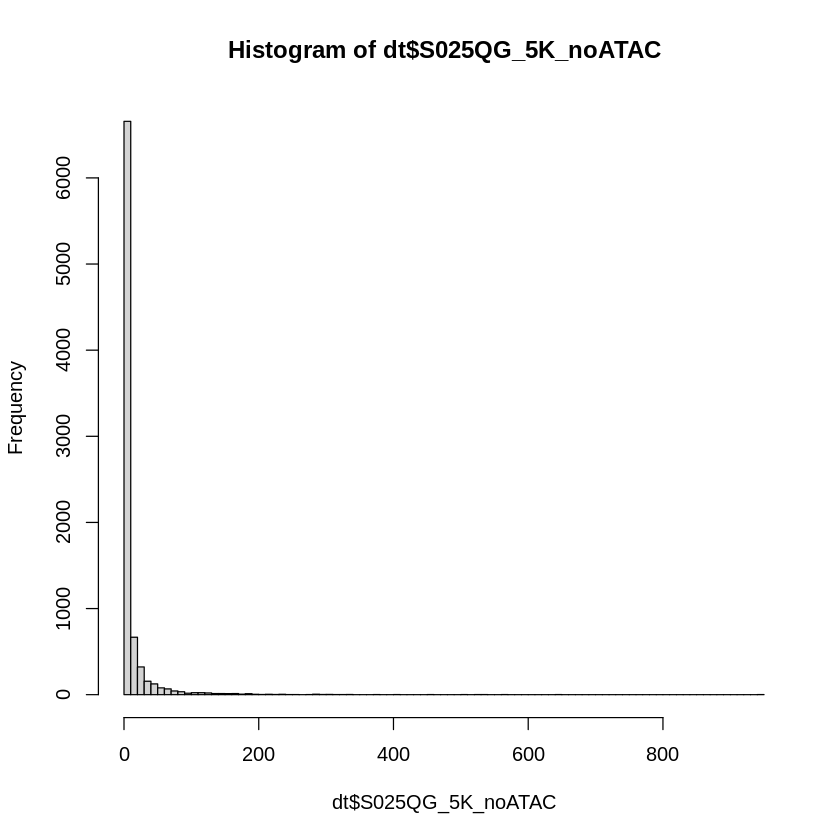

In [2]:
# gene expression data per individual
# peak matrix, intersected with ATAC peaks and assigned to genes
pm <- fread("~/HRJ_monocytes/CHiC/chicago/combinations_output/peakmatrix/mono_34reps_5K_peakmatrix.txt")
#baitName contains the gene name.
# intersect OE with ATAC peaks, called in consensus individuals.
peaks <- fread("./ATAC-seq/analyses/HMMRATAC/consensus/output/ATAC_merged_34reps_HMMRATAC_withBlacklist_peaks.bed")
names(peaks) = c("chrom", "ATAC_start", "ATAC_end", "ATACpeak")
pm[, oechrom := paste0("chr", oeChr)]
setkey(peaks, chrom, ATAC_start, ATAC_end)
# did this locally.
#pm_ATAC <- foverlaps(pm, peaks, by.x = c("oechrom", "oeStart", "oeEnd"))
baitTS <- fread("~/eCHiC/design/final_design/all_captured_genes_finalhg38.txt")
baitTS_small <- unique(baitTS[, .(cap_Gene, cap_ENSG_ID, Chrom, cap_TSS_start, cap_TSS_end)]) # 5K baitmap so have to do intersect
setkey(baitTS_small, Chrom, cap_TSS_start, cap_TSS_end)

pm_ATAC <- fread("./CHiC/chicago/combinations_output/peakmatrix/ATAC_merged_34reps_HMMRATAC_withBlacklist_peaks_5KPM_intersect.txt")
pm_ATAC_genes <- foverlaps(pm_ATAC, baitTS_small, by.x = c("oechrom", "baitStart", "baitEnd"), nomatch = NULL)

pm_ATAC_genes <- fread("./CHiC/chicago/combinations_output/peakmatrix/ATAC_merged_34reps_HMMRATAC_withBlacklist_peaks_5KPM_intersect_ENSG.txt")

pm_ATAC_genes[is.na(ATAC_end), atac := 0]
pm_ATAC_genes[!is.na(ATAC_end), atac := 1]

mysamples <- names(pm_ATAC_genes[, 20:53])
for(my_sample in mysamples) {
  sample_new <- paste0(my_sample, "_noATAC")
  pm_ATAC_genes[(get(my_sample)) >= 5, (sample_new) := atac]
  pm_ATAC_genes[(get(my_sample)) < 5, (sample_new) := 0]
}
# get the sum of all ATAC interactions per sample, per gene
mysamples <- names(pm_ATAC_genes[, 55:88]) 

dt <- unique(pm_ATAC_genes[, .(cap_ENSG_ID)])
for(my_sample in mysamples) {
  new_dt <- as.data.table(pm_ATAC_genes %>% select(cap_ENSG_ID, my_sample) %>% group_by(cap_ENSG_ID) %>% 
                            summarize(sum_per_gene = sum(get(my_sample))))
  dt <- dt[new_dt, on = "cap_ENSG_ID"]
  setnames(dt, "sum_per_gene", my_sample)
}

hist(dt$S025QG_5K_noATAC, breaks = 100)

#dir.create("./CHiC/chicago/findings/atac_gene_intersect")
#fwrite(dt, file = "./CHiC/chicago/findings/atac_gene_intersect/ATAC_interaction_counts_per_gene_per_individual.txt", 
#       sep = "\t", quote = F, row.names = F, col.names = T)

In [3]:
# Load the expression data
gene_expression <- fread("./eqtls/eQTL_analysis/normalise/mono_RNAseq_DEseq_NONnormalized_counts_34reps.txt")
gene_lengths <- fread("./eqtls/eQTL_analysis/input/gene_locs_format.txt")
gene_lengths[, length_kb := (right-left)/1000]
setkey(gene_lengths, geneid)
names(gene_expression)[1] = "gene_id"

gene_expression_lengths <- gene_expression[gene_lengths, on = c(gene_id = "geneid"), nomatch = NULL] 

# Prepare gene expression data for analysis
library(edgeR)
library(lme4)
library(tximport)

#TPM is very similar to RPKM and FPKM. The only difference is the order of operations. Here’s how you calculate TPM:
# 1, Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).
# 2, Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
# 3, Divide the RPK values by the “per million” scaling factor. This gives you TPM.
mysamples <- names(gene_expression_lengths[, 2:35]) # ???
for(my_sample in mysamples) {
  name_rpk <- paste0(my_sample, "_RPK")
  gene_expression_lengths[, (name_rpk) := get(my_sample)/length_kb]
  name_per_million <- paste0(my_sample, "_per_million")
  gene_expression_lengths[, (name_per_million) := sum(get(name_rpk))/1000000]
  name_TPM <- paste0(my_sample, "_TPM")
  gene_expression_lengths[, (name_TPM) := get(name_rpk)/get(name_per_million)]
}

# melt and connect with the ATAC data.
keep1 <- gene_expression_lengths[, grep(pattern="TPM", colnames(gene_expression_lengths))]
keep2 <- 1
keep_all <- c(keep2, keep1)
library(stringr)
gex <- gene_expression_lengths[, ..keep_all] 
names(gex) = str_replace_all(names(gex), "_TPM", "")

at_keep1 <- dt[, grep(pattern = "_noATAC", colnames(dt))]
at_keep2 <- 1
at_keep_all<- c(at_keep2, at_keep1)
atc <- dt[, ..at_keep_all]
names(atc) = str_replace_all(names(atc), "_5K_noATAC", "")
names(atc)[1] = "gene_id"

gex2 <- melt.data.table(gex, id.vars = "gene_id", measure.vars = names(gex[, 2:35]), variable.name = "Sample", value.name = "TPM")
atc2 <- melt.data.table(atc, id.vats = "gene_id", measure.vars = names(atc[, 2:35]), variable.name = "Sample", value.name = "CHiC_ATAC")

gexatc <- gex2[atc2, on = c("gene_id", "Sample"), nomatch = NULL]
#fwrite(gexatc, file = "./CHiC/chicago/findings/atac_gene_intersect/TPM_versus_CHiC_ATAC.txt", sep = "\t", quote = F, col.names = T, row.names = F)

Loading required package: limma

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




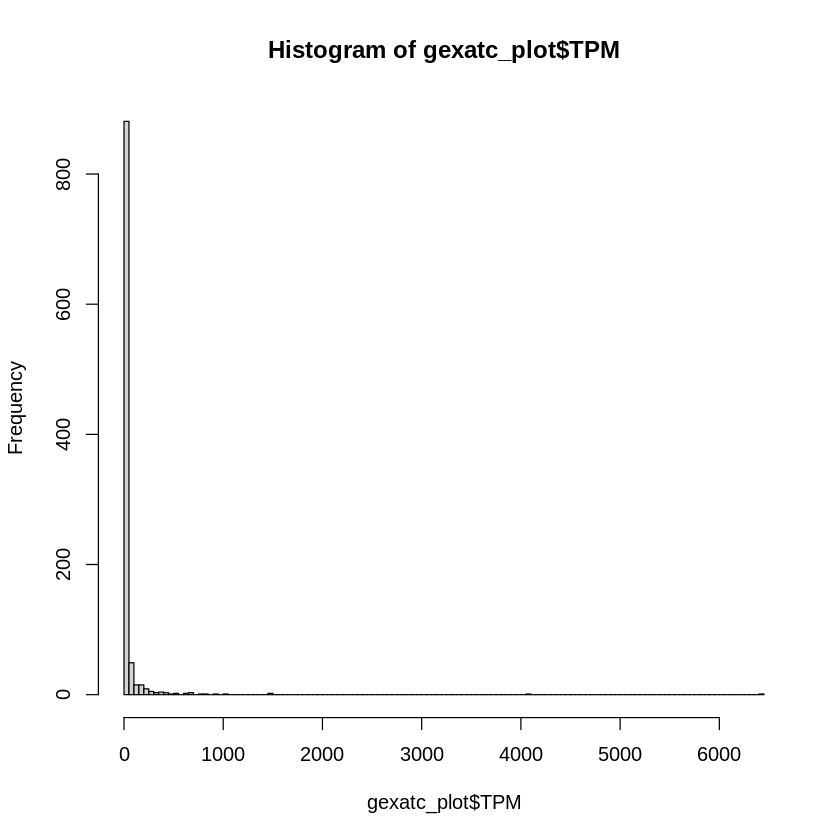

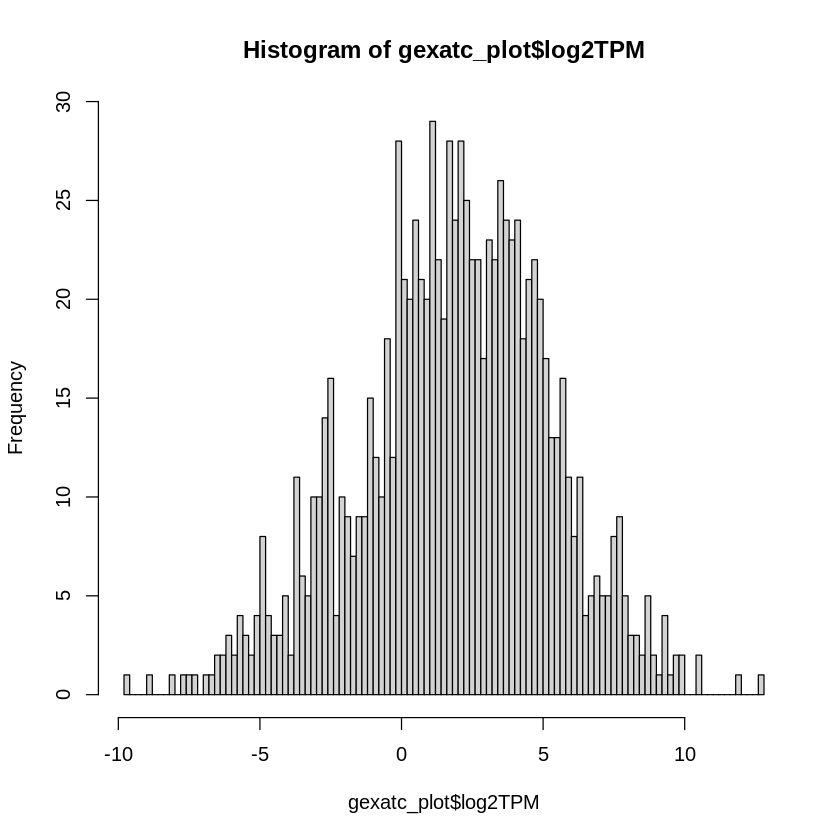

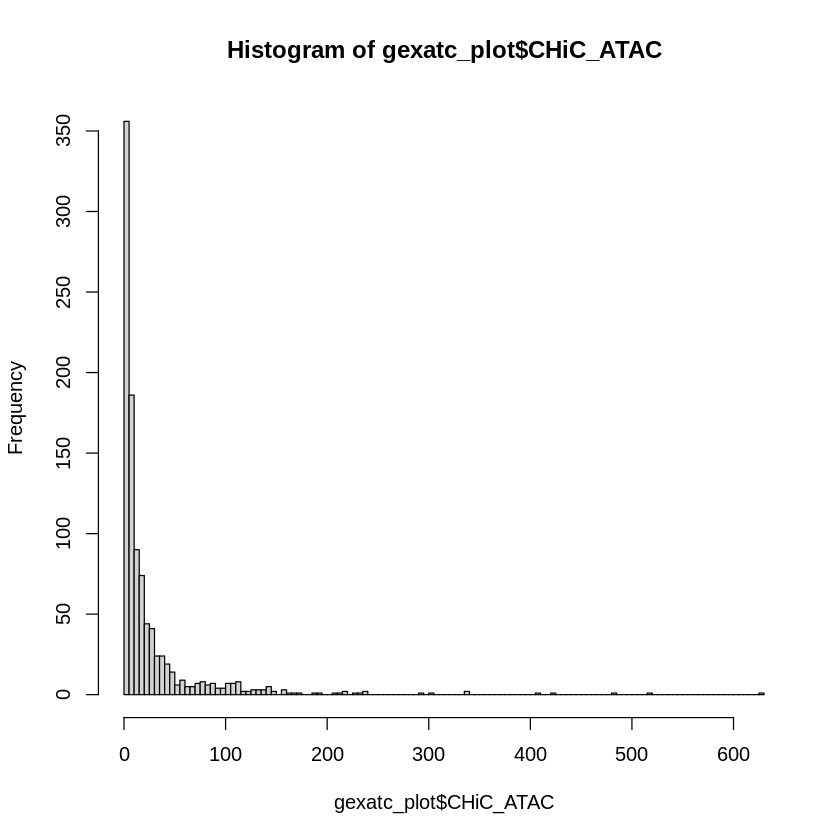

Warning message in cor.test.default(gexatc$log2CHiC_ATAC, gexatc$log2TPM, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  gexatc$log2CHiC_ATAC and gexatc$log2TPM
S = 1.5461e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2155873 


Warning message:
“Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”
`geom_smooth()` using formula = 'y ~ x'


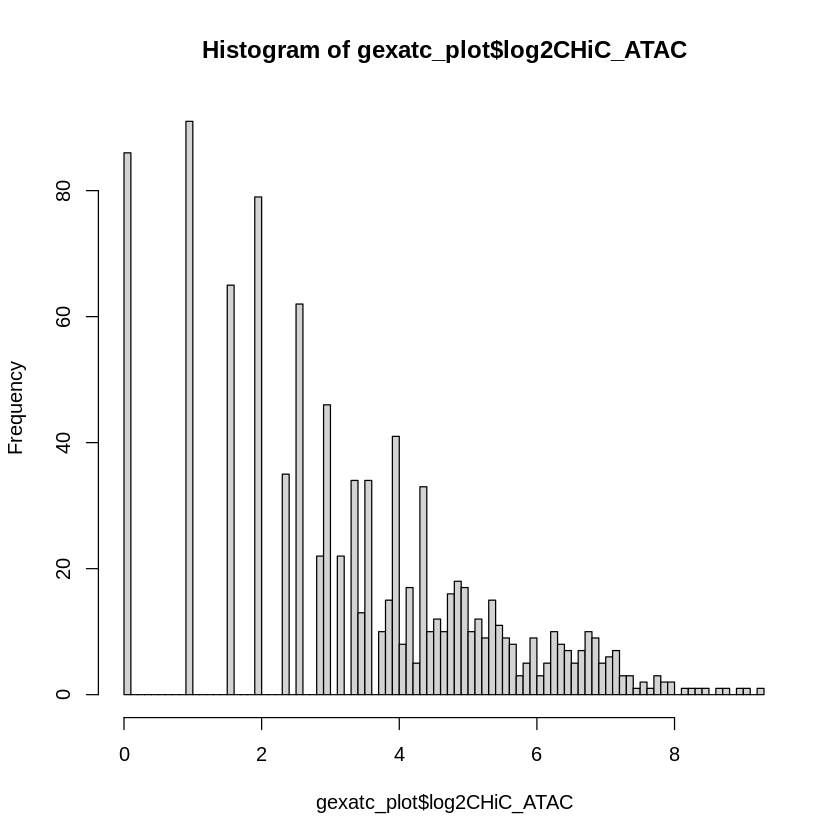

Warning message in cor.test.default(gexatc$log2CHiC_ATAC, gexatc$log2TPM, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  gexatc$log2CHiC_ATAC and gexatc$log2TPM
S = 1.5461e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2155873 


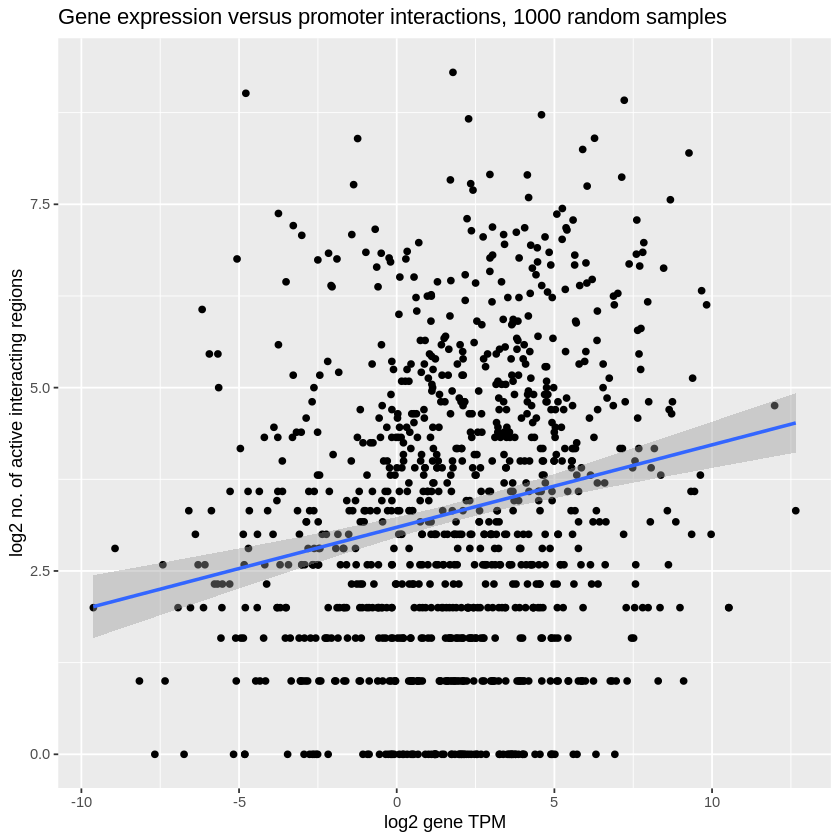

png 
  2


	Spearman's rank correlation rho

data:  gexatc$log2CHiC_ATAC and gexatc$log2TPM
S = 1.5461e+14, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2155873 


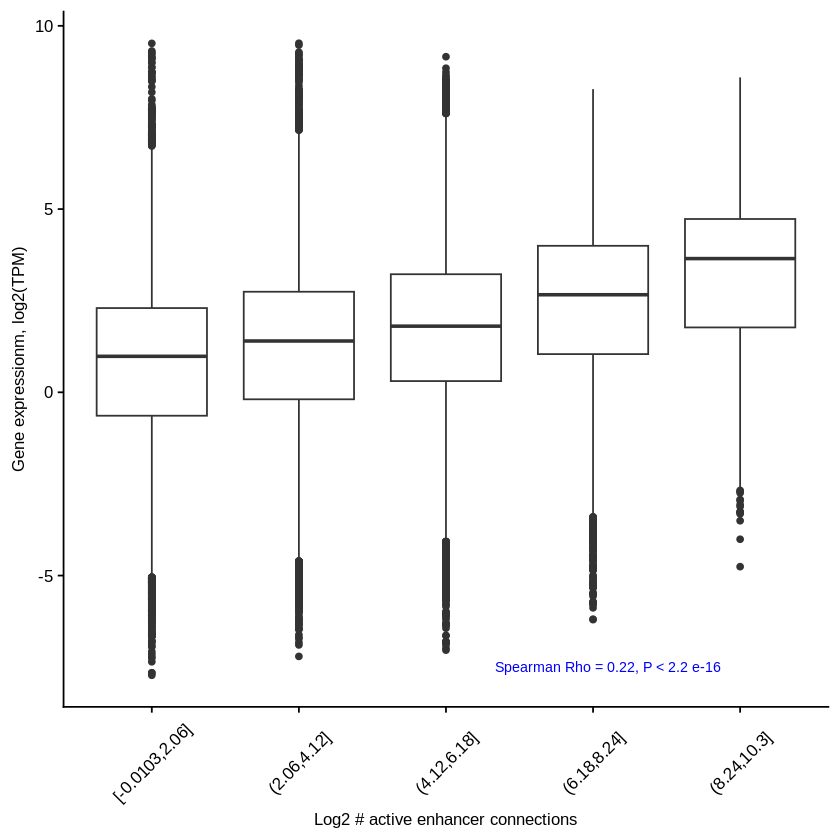

In [5]:
gexatc[, log2TPM := log2(TPM + 0.00001)] 
gexatc[, log2CHiC_ATAC := log2(CHiC_ATAC + 0.00001)] 
gexatc <- gexatc[TPM >0 & CHiC_ATAC > 0]
gexatc[, log2TPM := log2(TPM)] # 
gexatc[, log2CHiC_ATAC := log2(CHiC_ATAC)] # 
gexatc[, log10CHiC_ATAC := log10(CHiC_ATAC)]

look <- gexatc[TPM > 0]
look[, log2TPM := log2(TPM)]


sample_rows <-sample(nrow(gexatc), 1000)
gexatc_plot <- gexatc[sample_rows, ]
#look_plot <- look[sample_rows, ]
hist(gexatc_plot$TPM, breaks = 100) 
hist(gexatc_plot$log2TPM, breaks = 100) 
hist(gexatc_plot$CHiC_ATAC, breaks = 100) 
hist(gexatc_plot$log2CHiC_ATAC, breaks = 100) # This is still quite skewed towards zero
# we should do Spearman's rank correlation coefficient

spear <- cor.test(gexatc$log2CHiC_ATAC, gexatc$log2TPM, method = "spearman")
spear # p < 2,2 e-16

# Scatterplot version
ggplot(gexatc_plot, aes(x = log2TPM, y = log2CHiC_ATAC)) + geom_point() +
  stat_summary(fun.data= mean_cl_normal) + 
  geom_smooth(method='lm') +
  xlab("log2 gene TPM") +
  ylab("log2 no. of active interacting regions") +
  ggtitle("Gene expression versus promoter interactions, 1000 random samples")
gexatc[, TPM_bin := cut(log2TPM, breaks= 5, include.lowest = T)]
gexatc[, Enhancer_bin := cut(log2CHiC_ATAC, breaks= 5, include.lowest = T)]

spear <- cor.test(gexatc$log2CHiC_ATAC, gexatc$log2TPM, method = "spearman")
spear # p < 2,2 e-16, Rho = 0.2155873

# Boxplot version
ggplot(gexatc, aes(x = Enhancer_bin, y = log(TPM))) + geom_boxplot() + 
  #geom_jitter(height = 0, width = 0.2, colour = "grey") + too many points!
  ylab("Gene expressionm, log2(TPM)") +
  xlab("Log2 # active enhancer connections") +
  theme_half_open() + # you have to call the cowplot theme beofre doing other things with theme
  theme(text = element_text(size = 10), 
        axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5, size = 10), 
        axis.text.y = element_text(size = 10)) +
  annotate("text", x=4.1, y=-7.5, label= "Spearman Rho = 0.22, P < 2.2 e-16", colour = "blue", size = 3) 

pdf(file = "~/HRJ_monocytes/paper/fig_pdfs/expresion_v_gene_interactions.pdf", width = 6, height = 5)
ggplot(gexatc, aes(x = Enhancer_bin, y = log(TPM))) + geom_boxplot() + 
  #geom_jitter(height = 0, width = 0.2, colour = "grey") + too many points!
  ylab("Gene expressionm, log2(TPM)") +
  xlab("Log2 # active enhancer connections") +
  theme_half_open() + # you have to call the cowplot theme beofre doing other things with theme
  theme(text = element_text(size = 10), 
        axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5, size = 10), 
        axis.text.y = element_text(size = 10)) +
  annotate("text", x=4.1, y=-7.5, label= "Spearman Rho = 0.22, P < 2.2 e-16", colour = "blue", size = 3) 
  
dev.off()

spear # p < 2,2 e-16
